In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
from shapely.geometry import Point
from shapely.ops import cascaded_union
from matplotlib.collections import PolyCollection

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.dataset import Haplotype
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

# load the model and use valid data 

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model
labels_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_pca')
data_path = osp.join(os.environ['OUT_PATH'],'humans/labels/data_id_1_pca')
models_path=osp.join(os.environ['OUT_PATH'],'humans/training/Model_Q_exp_id_1_data_id_1_pca/') 
dataset_type='test'

In [6]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
yaml_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(yaml_path), "No json configuration file found at {}".format(yaml_path)
params = Params(yaml_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.balancedLoss=False
results, test_dataset,_,_=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (564, 317410)
INFO: __init__:src.main.dataset: y_labels data :(564, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.3991 secs
Finished 'pop_mapping' in 0.1361 secs
Finished 'pop_mapping' in 0.1330 secs
Finished 'transform_data' in 37.1720 secs
Finished '__init__' in 116.6416 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 3.0943 secs
best val loss metrics : {'loss_main': 0.32982670098526423, 'loss_aux': 0.8378495132421891, 'gcd': None, 'mse': 0.17319945671879727, 'smooth_l1': 0.08350094807714122, 'weighted_loss': 0.32982670098526423}
at epoch : 131
train loss metrics: {'loss_main': 0.31123373579025687, 'loss_aux': 0.7249774828171883, 'gcd': None, 'mse': 0.09206160483954577, 'smooth_l1': 0.045924477757158993, 'weighted_loss': 0.31123373579025687}
best val cp metrics : {'loss_cp': 0.2588518878027973, 'prMetrics': OrderedDict([('Precision', array(0.36076843)), ('Recall', array(0.73315897)), 

In [7]:
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

INFO: __init__:src.main.dataset: Loading train Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (4116, 317410)
INFO: __init__:src.main.dataset: y_labels data :(4116, 317410)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished 'mapping_func' in 0.7911 secs
Finished 'pop_mapping' in 0.2829 secs
Finished 'pop_mapping' in 0.2772 secs
Finished 'transform_data' in 81.2802 secs
Finished '__init__' in 250.4384 secs


In [8]:
results.t_accr, results.t_cp_accr

({'gcd': None,
  'loss_aux': 0.8257106522353415,
  'loss_main': 0.34881317330042527,
  'mse': 0.20765687119979714,
  'smooth_l1': 0.09909649644977372,
  'weighted_loss': 0.34881317330042527},
 {'loss_cp': 0.3220519820755214,
  'prMetrics': OrderedDict([('Precision', array(0.4193191)),
               ('Recall', array(0.71403421)),
               ('Accuracy', array(0.97842246)),
               ('A_major', array(0.9829747)),
               ('BalancedAccuracy', 0.8485044511028391)])})

In [9]:
results.t_out.coord_main=results.t_out.coord_main.mean(0)

In [10]:
y_pred = results.t_out.coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 193.4293 secs


In [11]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superpop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
rev_sp_dict={v:k for k,v in superpop_dict.items()}

In [12]:
# index = 2500
# index=2620
# index=2650
# index=3000
# index=3100
index=1916
# index=np.random.choice(idxOfInterest)
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results.t_out.coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
superPopSample=test_dataset.data['superpop'][index,:]
SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

1916


In [13]:
y_predSample.shape

(317, 3)

In [14]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, len(true_cpsSample))
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [15]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 3.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [16]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [17]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.reshape(-1,3))

Finished 'nearestNeighbourMapping' in 0.2466 secs


In [18]:
mappedSpArr.shape

(317,)

In [19]:
y_True=train_dataset.data['y'].reshape(-1,3)
superpopsTrue=train_dataset.data['superpop'].reshape(-1,)

In [20]:
def linear_gradient(start_rgb, finish_rgb, n):
    ''' returns a gradient list of (n) colors between
      two rgb colors. start_rgb and finish_rgb
       '''
    # Initilize a list of the output colors with the starting color
    RGB_list = [start_rgb]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
            (start_rgb[j] + (float(t)/(n-1))*(finish_rgb[j]-start_rgb[j]))
            for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)
    
    return RGB_list

In [21]:
def getColorsPop(granularpopSample, superPopSample, colorsSP_dict):
    counterSPUsed={k:0 for k in range(7)}
    haploGp ={}
    gpMap2Sp_Color={}
    for i in np.unique(granularpopSample):
        idx=np.nonzero(granularpopSample==i)[0][0]
        sp=superPopSample[idx]
        colorIdx=3*counterSPUsed[sp]+3 # because we want to pick alternate colors separated by 2 hops
        gpMap2Sp_Color[i]=(sp,colorIdx)
        counterSPUsed[sp] +=1
    
    spGradient=getGradient(counterSPUsed, colorsSP_dict)
    
    for i in np.unique(granularpopSample):
        haploGp[i]=spGradient[gpMap2Sp_Color[i][0]][gpMap2Sp_Color[i][1]]
    
    return haploGp, counterSPUsed, gpMap2Sp_Color

In [22]:
def formColorMapBySP(superpop_dict):
    print(superpop_dict)
    continentalPops=[superpop_dict['EUR'], superpop_dict['EAS'], superpop_dict['OCE'], superpop_dict['SAS'],\
                 superpop_dict['AFR'], superpop_dict['AMR'], superpop_dict['WAS']]
    colors_pop = sns.color_palette("bright", 10)
    del colors_pop[1]
    del colors_pop[4]
    del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentalPops, colors_pop)}
    return colors_pop_dict

def getGradient(counterSPUsed, colorsSP_dict):
    spGradient={}
    for k,v in colorsSP_dict.items():
        if counterSPUsed[k]>0:
            if k<=len(colorsSP_dict)-2:
                finish_rgb=k+1
            else:
                finish_rgb=0
            spGradient[k]=linear_gradient(start_rgb=v, finish_rgb=[1.0, 1.0, 1.0],\
            n= max(10,3*counterSPUsed[k]+3))

    return spGradient

In [23]:
@timer
def plot_all(ax, y_preds, superpops, reduce_alpha=0.03, size=0.05, zorder=-1,**kwargs):
    plt.rcParams['lines.solid_capstyle'] = 'round'
    def expand(x, y, z, gap=1e-4):
        add = np.tile([0, gap, np.nan], len(x))
        x1 = np.repeat(x, 3) + add
        y1 = np.repeat(y, 3) + add
        z1 = np.repeat(z, 3) + add
        return x1, y1, z1
    
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps') 
    superpop_dict=kwargs.get('superpop_dict')
    print(superpop_dict)
    colors_pop_dict = formColorMapBySP(superpop_dict)
    
    alpha=[1.0]*len(y_preds)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
        
    colors_pop_dict2={}  
    continentalPops=list(superpop_dict.values())
    for pop in continentalPops:
        start_rgb=colors_pop_dict[pop]
        finish_rgb=(1.,1.,1.)
        n=10
        colors_pop_dict2[pop]=linear_gradient(start_rgb, finish_rgb, n)[0]
    for pop in continentalPops:
        idx = np.where(superpops==pop)[0]
        ax.plot(*expand(y_preds[idx,0], y_preds[idx,1], y_preds[idx,2]), \
               color = colors_pop_dict[pop], alpha=0.2, linewidth=12) 
    
    return colors_pop_dict

In [24]:
@timer
def plot_sample(granularPopSample, y_predSample, y_trueSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_trainTrue=kwargs.get('y_trainTrue')
    superpops=kwargs.get('superpops')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    superPopSample=kwargs.get('superPopSample')
    superpop_dict=kwargs.get('superpop_dict')
    
    fig, ax = plt.subplots(figsize=(13,11))
    plt.rcParams['hatch.color']='grey'
    
    gs1 = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[13,2,2])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax1.set_xlim(np.array([-2,2])*.77)
    ax1.set_ylim(np.array([-2,2])*.77)
    ax1.set_zlim(np.array([-2,2])*.77)
    ax2=fig.add_subplot(gs1[1])
    ax3=fig.add_subplot(gs1[2])
    for axis in [ax, ax2, ax3]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    fig.subplots_adjust(left=-0.5, right=-0.49, bottom=0.0, top=0.4)
    plt.subplots_adjust(hspace=-0.9)
    
    if backgroundAxis:
        colorsPop_sp_dict =plot_all(ax1, y_trainTrue, superpops, reduce_alpha=1.0, size=100, \
                            superpop_dict=superpop_dict, cpShow=False)
    else:
        colorsPop_sp_dict = formColorMapBySP(superpop_dict)
        
    patches=[]
    for k, val in superpop_dict.items():
        patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
    lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.37, 1., .5))

    ax1.add_artist(lgnd)
    colors_Gp_dict,_,_=getColorsPop(granularpopSample, superPopSample, colorsPop_sp_dict)
    colors_pop_dict=colors_Gp_dict

    alpha=[1]*len(y_predSample)
    
    unknownIdx=np.nonzero(pred_cps)[0]
    print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)/len(y_predSample)}")
    granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
    colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
    mappedSpArr[unknownIdx]=-1
    colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
    knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
        
    # No effect of zorder arg because its a 3d plot and has z axis
    ax1.scatter(y_predSample[knownIdx,0], y_predSample[knownIdx,1], y_predSample[knownIdx,2],\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in knownIdx], alpha)], \
    s=200, zorder=0, edgecolor='black', linewidth=1.)
    
    if cpShow:
        ax1.scatter(y_predSample[unknownIdx,0], y_predSample[unknownIdx,1], y_predSample[unknownIdx,2], facecolor='grey', hatch=3*'+',\
        color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in unknownIdx], alpha)], s=50, zorder=0) 
    
    #ToDo: plot only the unique trueSample instead of all the windows
    ax1.scatter(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2], \
    color = [tuple(colors_pop_dict[x]) for x in granularPopSample], marker='X', s=300, zorder=0, \
    edgecolor='black', linewidth=1.5)
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(ax1.scatter([],[],color = colors_pop_dict[val], marker='o', s=400, edgecolor='black', linewidth=0.5, label = rev_pop_dict[val]))
    patches.append(ax1.scatter([],[], color = (1, 1, 1, 0.5), marker='X', s=400, edgecolor='black', linewidth=1.5, label = "Target Location")) #add training locations
    patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=3*'+')) #add UNK legend patch separately
    ax1.legend(handles=patches, loc="upper left", fontsize=20, bbox_to_anchor=(-0.03, -0.1, 1, 1))
    #chm plot ground truth
    ax2.bar(np.arange(len(y_trueSample)), zorder=0.2,\
    color=[colors_pop_dict[x] for x in granularPopSample], width=1.0, height=1.02)
    if kwargs.get('title_enable') is not None:
        ax2.set_title('Ground Truth', fontsize=30, y=0.3, loc='left')
    
    #chm plot of predictions
    ax3.bar(knownIdx, 1.02*np.ones(len(mappedSpArr[knownIdx])), \
            color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], \
            width=1.0)
    ax3.bar(unknownIdx, 1.02*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=3*"+")
    if kwargs.get('title_enable') is not None:
        ax3.set_title('Predicted', fontsize=30, y=0.3, loc='left')
    
    xtickOffsetBegin=2
    xtickOffsetEnd=-26
    for ax in [ax3]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=30)
        ax.tick_params(which='minor', width=2, length=10, labelsize=10)
        ax.set_xlim(0, params.n_win)
        ax.set_ylim(0.99,1.09)
        positions = [0+xtickOffsetBegin, int(params.n_win/2), params.n_win+xtickOffsetEnd]
        x_labels = [0, int(params.n_win*params.win_size/2), params.n_win*params.win_size]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("center")
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
    ax2.xaxis.set_ticks_position('bottom')
    ax2.tick_params(which='major', width=2, length=10)
    ax2.tick_params(which='minor', width=2, length=10)
    ax2.set_xlim(0, params.n_win)
    ax2.set_ylim(0.99,1.09)
    ax2.xaxis.set_major_locator(ticker.FixedLocator([]))
    ax2.xaxis.set_major_formatter(ticker.FixedFormatter([]))
    
    
    plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
#     plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
    plt.show()
    plt.close('all')

{'EUR': 0, 'EAS': 1, 'AMR': 2, 'SAS': 3, 'AFR': 4, 'OCE': 5, 'WAS': 6}
{'EUR': 0, 'EAS': 1, 'AMR': 2, 'SAS': 3, 'AFR': 4, 'OCE': 5, 'WAS': 6}
Finished 'plot_all' in 0.6582 secs
number of changepoints removed:55,0.17350157728706625


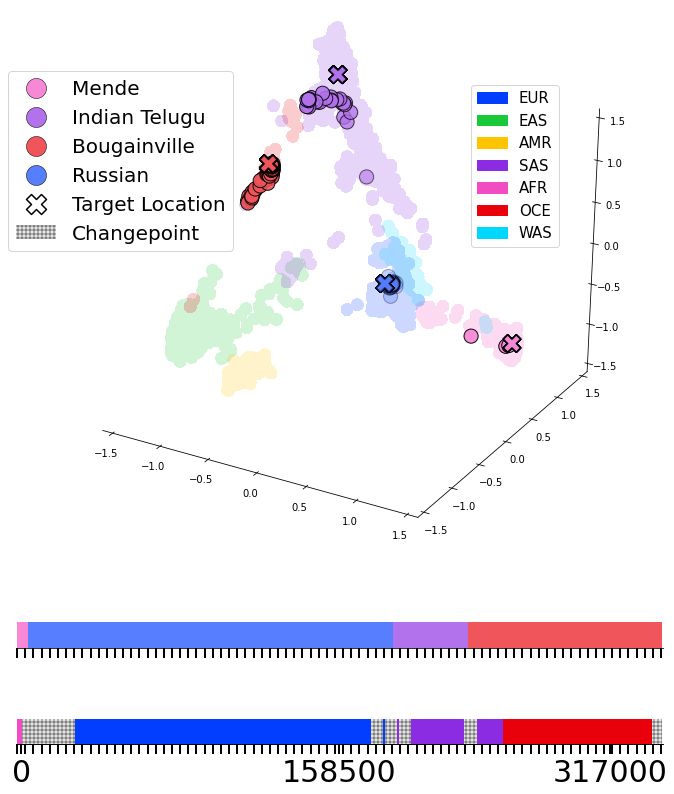

Finished 'plot_sample' in 13.3342 secs


In [25]:
plot_sample(granularpopSample, y_predSample, y_trueSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_trainTrue=y_True, superpops=superpopsTrue, superPopSample=superPopSample, superpop_dict=superpop_dict, cpShow=False)

In [ ]:
y_preds=results.t_out.coord_main
y_predCps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, y_preds.shape[0], y_preds.shape[1])
y_predCps=y_predCps.detach().cpu().numpy().reshape(-1,)
y_preds=y_preds.reshape(-1,3)
superpops=test_dataset.data['superpop'].reshape(-1,)

In [91]:
superpop_dict

{'AFR': 4, 'AMR': 2, 'EAS': 1, 'EUR': 0, 'OCE': 5, 'SAS': 3, 'WAS': 6}

In [576]:
idxOfInterest1=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Bedouin"])[0])
idxOfInterest2=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Bedouin"])[0])
idxOfInterest3=np.unique(np.nonzero(test_dataset.data['granular_pop']==granular_pop_dict["Bedouin"])[0])
idxOfInterest=np.intersect1d(idxOfInterest1, idxOfInterest2)
idxOfInterest=np.intersect1d(idxOfInterest, idxOfInterest3)

granular_pop:Finnish
superpop:EUR


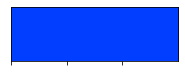

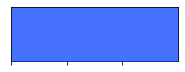

granular_pop:Spanish
superpop:EUR


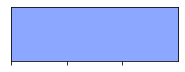

granular_pop:Peruvian
superpop:AMR


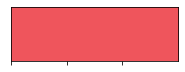

granular_pop:Gambian Mandinka
superpop:AFR


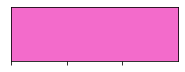

granular_pop:Esan
superpop:AFR


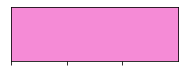

granular_pop:Indian Telugu
superpop:SAS


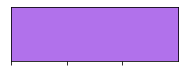

granular_pop:Yoruba
superpop:AFR


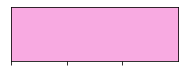

granular_pop:Tuscan
superpop:EUR


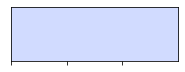

granular_pop:Brahui
superpop:SAS


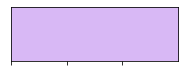

granular_pop:San
superpop:AFR


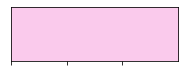

granular_pop:Mozabite
superpop:AFR


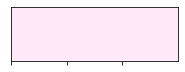

In [37]:
for k, v in colors_Gp_dict.items():
    print(f"granular_pop:{rev_pop_dict[int(k)]}")
    print(f"superpop:{rev_sp_dict[int(gpMap2Sp_Color[k][0])]}")
    sns.palplot(v)
    plt.show()


In [50]:
continentaPops=list(superop_dict.keys())
for i in range(7):
    print(f"{continentaPops[i]} color")
    sns.palplot(colorsSP_dict[i])
    print("gradient color")
    sns.palplot(spGradient[i])
    plt.show()
plt.close('all')

EUR color
gradient color


NameError: name 'spGradient' is not defined

In [39]:
granular_pop_dict

{'Abkhasian': 114,
 'Adygei': 70,
 'Albanian': 115,
 'Altaian': 87,
 'Ami': 97,
 'Armenian': 116,
 'Atayal': 98,
 'Australian': 74,
 'Balochi': 22,
 'BantuHerero': 76,
 'BantuKenya': 71,
 'BantuSouthAfrica': 49,
 'BantuTswana': 77,
 'Basque': 69,
 'Bedouin': 36,
 'Bengali': 10,
 'Bergamo_Italian': 53,
 'Biaka': 30,
 'Bougainville': 31,
 'Brahmin': 105,
 'Brahui': 21,
 'British': 0,
 'Bulgarian': 117,
 'Burmese': 99,
 'Burusho': 28,
 'Cambodian': 40,
 'Chane': 83,
 'Chechen': 118,
 'Colombian': 39,
 'Crete': 75,
 'Czech': 119,
 'Dai': 64,
 'Dai Chinese': 3,
 'Daur': 57,
 'Dinka': 72,
 'Druze': 35,
 'Dusun': 103,
 'Esan': 9,
 'Eskimo_Chaplin': 88,
 'Eskimo_Naukan': 89,
 'Eskimo_Sireniki': 90,
 'Estonian': 120,
 'Even': 91,
 'Finnish': 1,
 'French': 32,
 'Gambian Mandinka': 8,
 'Georgian_Mingrelian': 121,
 'Greek': 122,
 'Gujarati': 20,
 'Han': 41,
 'Han Chinese': 15,
 'Hazara': 23,
 'Hezhen': 59,
 'Hungarian': 123,
 'Icelandic': 124,
 'Igorot': 104,
 'Indian Telugu': 13,
 'Iranian': 125,

In [ ]:
spGradient[3]

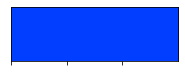

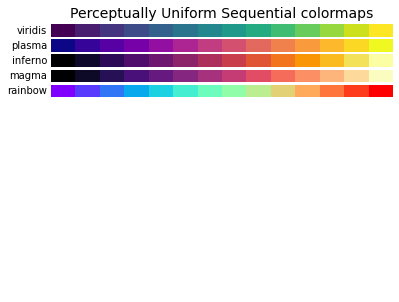

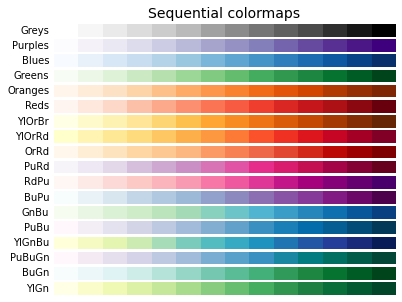

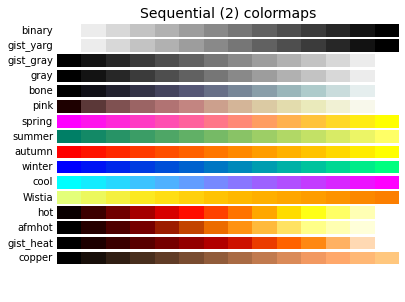

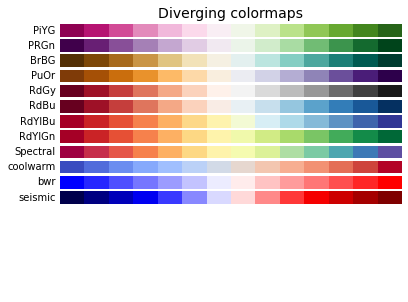

In [40]:
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma','rainbow']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ]


nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps)
gradient = np.linspace(0, 1, 14)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps:
    plot_color_gradients(cmap_category, cmap_list, nrows)

plt.show()

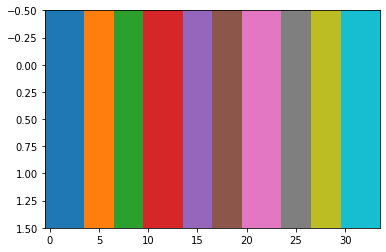

In [41]:
fig,ax=plt.subplots()
gradient = np.linspace(0, 1, 34)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap='tab10')
plt.show()

In [42]:
gradient

array([[0.        , 0.03030303, 0.06060606, 0.09090909, 0.12121212,
        0.15151515, 0.18181818, 0.21212121, 0.24242424, 0.27272727,
        0.3030303 , 0.33333333, 0.36363636, 0.39393939, 0.42424242,
        0.45454545, 0.48484848, 0.51515152, 0.54545455, 0.57575758,
        0.60606061, 0.63636364, 0.66666667, 0.6969697 , 0.72727273,
        0.75757576, 0.78787879, 0.81818182, 0.84848485, 0.87878788,
        0.90909091, 0.93939394, 0.96969697, 1.        ],
       [0.        , 0.03030303, 0.06060606, 0.09090909, 0.12121212,
        0.15151515, 0.18181818, 0.21212121, 0.24242424, 0.27272727,
        0.3030303 , 0.33333333, 0.36363636, 0.39393939, 0.42424242,
        0.45454545, 0.48484848, 0.51515152, 0.54545455, 0.57575758,
        0.60606061, 0.63636364, 0.66666667, 0.6969697 , 0.72727273,
        0.75757576, 0.78787879, 0.81818182, 0.84848485, 0.87878788,
        0.90909091, 0.93939394, 0.96969697, 1.        ]])

In [43]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]

    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)


def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))

    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])
    plt.show()

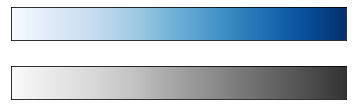

In [44]:
view_colormap('Blues')

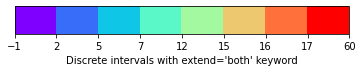

In [45]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.rainbow
bounds = [-1, 2, 5, 7, 12, 15,16,17,60]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")
plt.show()

In [46]:
mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

In [47]:
colors_Gp_dict

{1: [0.2784313725490196, 0.449554367201426, 1.0],
 4: [0.5490196078431372, 0.6559714795008912, 1.0],
 5: [0.9398692810457516, 0.3333333333333333, 0.36209150326797385],
 8: [0.9547866205305652, 0.4219146482122261, 0.7997693194925029],
 9: [0.964475201845444, 0.5457900807381776, 0.8426758938869665],
 13: [0.6967320261437908, 0.4457516339869281, 0.9241830065359476],
 14: [0.9741637831603229, 0.6696655132641292, 0.8855824682814302],
 19: [0.819607843137255, 0.8623885918003565, 1.0],
 21: [0.8483660130718954, 0.7228758169934639, 0.9620915032679739],
 48: [0.9838523644752019, 0.7935409457900807, 0.9284890426758938],
 61: [0.9935409457900808, 0.9174163783160323, 0.9713956170703575]}

In [48]:
from matplotlib.colors import LinearSegmentedColormap
LinearSegmentedColormap.from_list(name="custom", colors=list(colors_Gp_dict.values()))

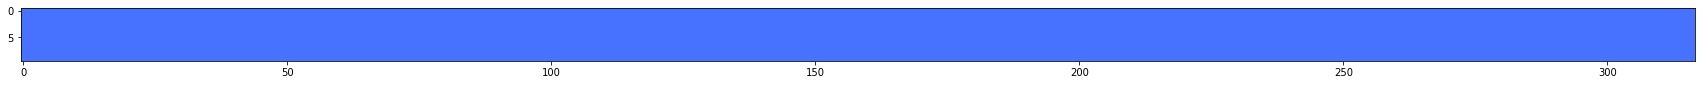

In [49]:
fig,ax=plt.subplots(figsize=(30,14))
ax.imshow(np.ones(shape=(10,317)), cmap=LinearSegmentedColormap.from_list(name="custom", colors=list(colors_Gp_dict.values())))
plt.show()

In [30]:
def plot_changepoints(true_cps, pred_cps, y_pred, bocp_rl, y_var, popNames):
    fig, ax = plt.subplots(4,1,figsize=[18,20])
    T=len(true_cps)
    ax[0].plot(y_pred)
    ax[0].text(0, np.max(y_pred)-0.5, s=popNames[0], size=15)
    for i in np.nonzero(true_cps)[0]:
        ax[0].plot([i,i], [np.min(y_pred), np.max(y_pred)], 'r' )
        ax[0].text(i, np.max(y_pred)-0.5, s=popNames[i+1], size=15)
    
    ax[1].plot(np.arange(T+1), bocp_rl)
    ax[2].plot(pred_cps)
    ax[3].plot(true_cps)
    
    ax[0].set_title("n_vectors")
    ax[1].set_title("BOCD (post process) run_length")
    ax[2].set_title("BOCD (post process) cp")
    ax[3].set_title("True Cps")
    plt.show()

In [273]:
bocp_rlSample

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   2.,   3.,   4.,
         4.,   5.,   6.,   1.,   2.,   3.,   4.,   5.,   2.,   3.,   4.,
         5.,   1.,   2.,   3.,   4.,   5.,   2.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
        17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
        28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
        72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 12

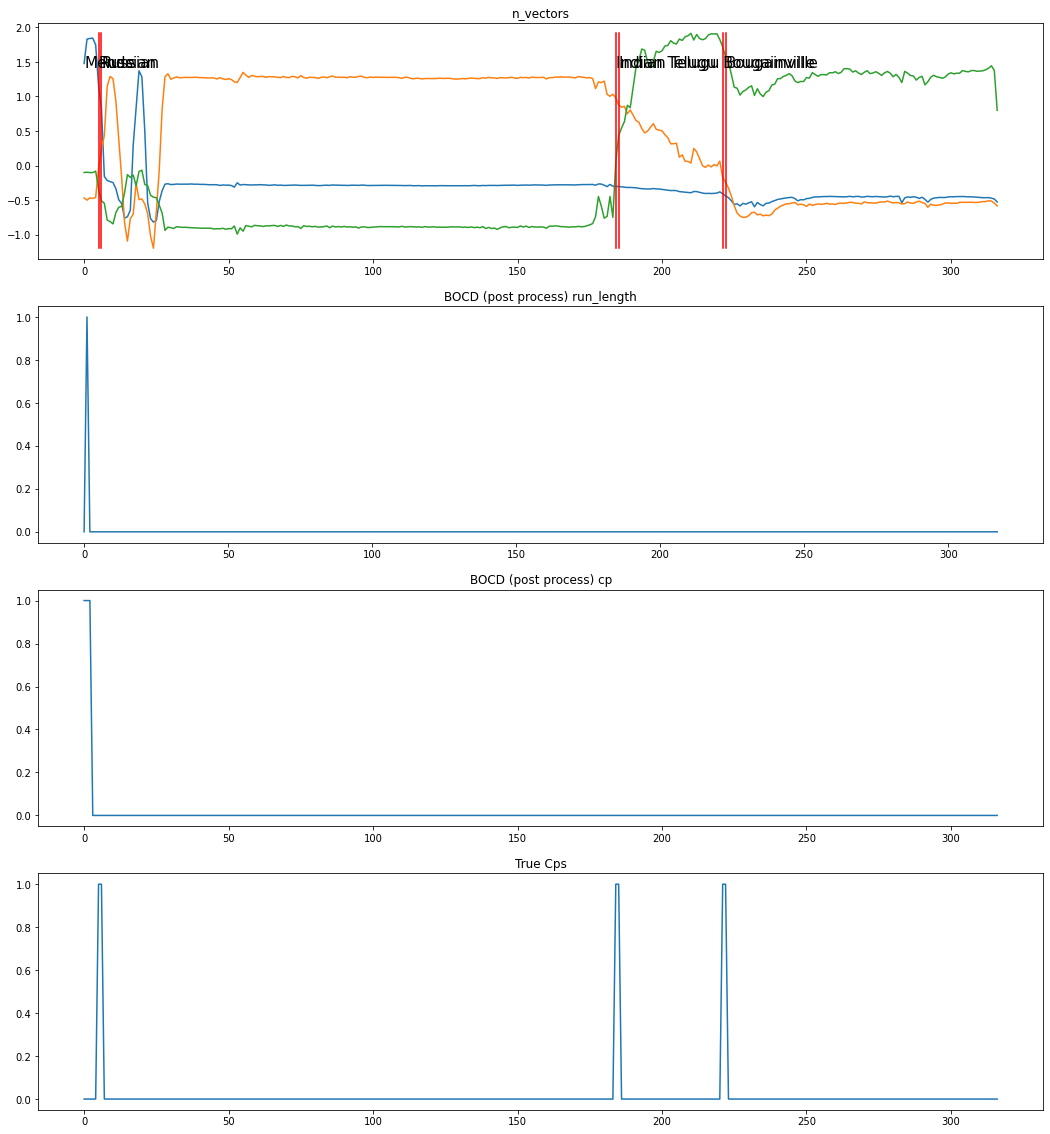

In [31]:
y_var=y_predSample[:,1:]-y_predSample[:,:-1]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
plot_changepoints(true_cpsSample, pred_cps_BOCD, y_predSample, bocp_rlSample, y_var, namesSample)

Finished 'plot_all' in 21.3972 secs


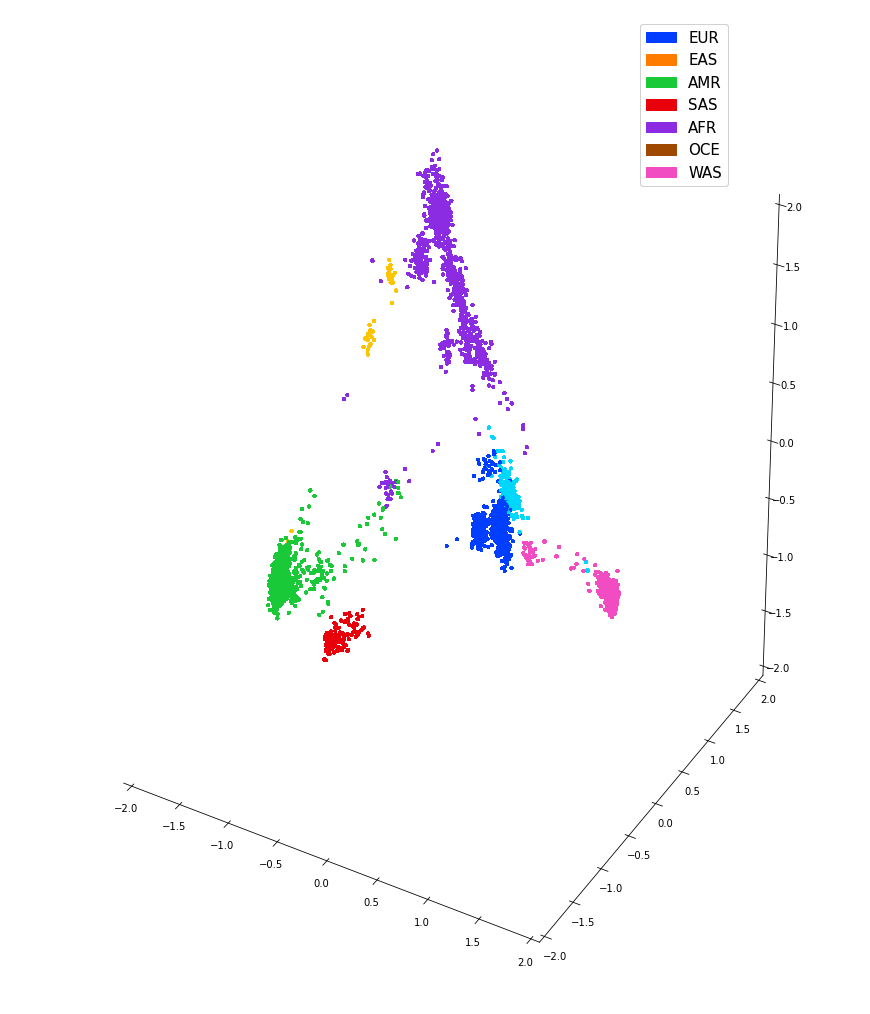

In [651]:
fig, ax = plt.subplots(figsize=(12,14))
gs1 = fig.add_gridspec(nrows=1, ncols=1)
ax1=fig.add_subplot(gs1[0],projection='3d')
ax1.set_xlim(np.array([-2,2]))
ax1.set_ylim(np.array([-2,2]))
ax1.set_zlim(np.array([-2,2]))
for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis._axinfo["grid"]['color'] = (1,1,1,0)
for axis in [ax, ax1]:
    axis.spines['top'].set_color('none')
    axis.spines['left'].set_color('none')
    axis.spines['right'].set_color('none')
    axis.spines['bottom'].set_color('none')
ax.set_xticks([])
ax.set_yticks([])

plot_all(ax1, y_predsTrue, superpopsTrue, reduce_alpha=1.0, size=20, zorder=5, cpShow=False)
continentaPops=list(superop_dict.values())
colorsPop_sp = sns.color_palette("bright", 10)
colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}

patches=[]
for k, val in superop_dict.items():
    patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
ax1.add_artist(lgnd)
plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
plt.show()

Finished 'plot_all' in 9.7672 secs


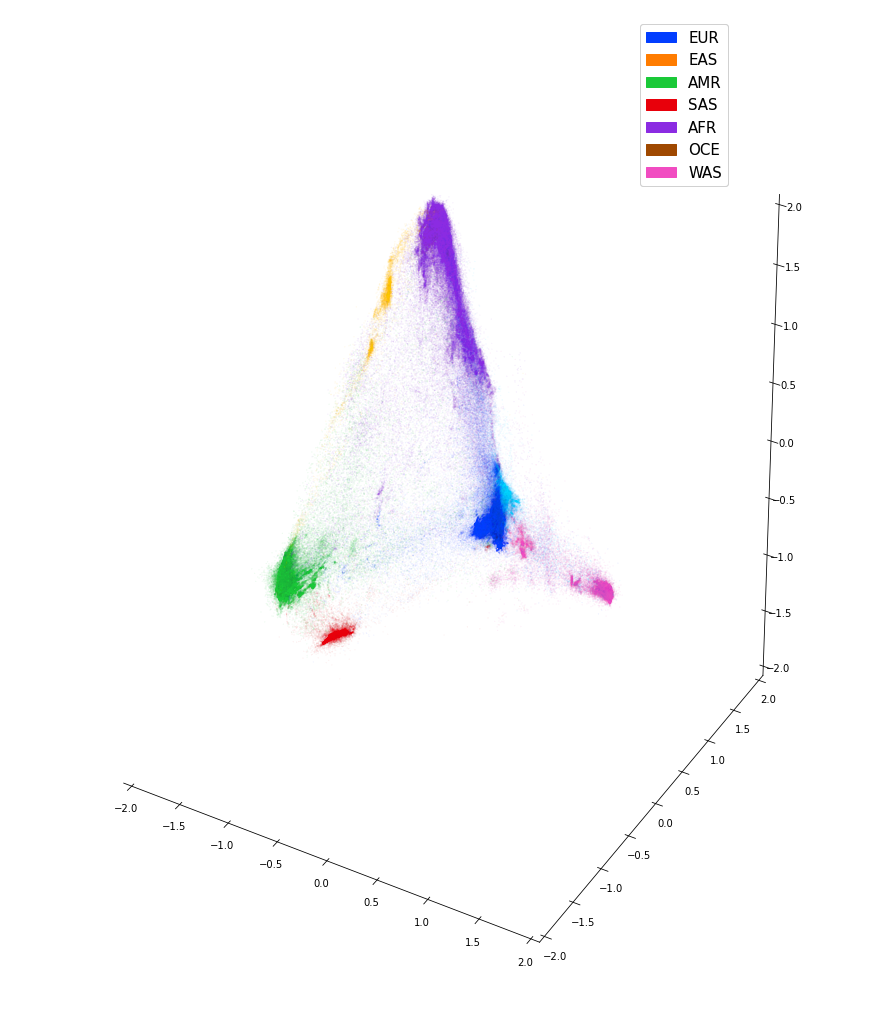

In [655]:
fig, ax = plt.subplots(figsize=(12,14))
gs1 = fig.add_gridspec(nrows=1, ncols=1)
ax1=fig.add_subplot(gs1[0],projection='3d')
ax1.set_xlim(np.array([-2,2]))
ax1.set_ylim(np.array([-2,2]))
ax1.set_zlim(np.array([-2,2]))
for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
    axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    axis._axinfo["grid"]['color'] = (1,1,1,0)
for axis in [ax, ax1]:
    axis.spines['top'].set_color('none')
    axis.spines['left'].set_color('none')
    axis.spines['right'].set_color('none')
    axis.spines['bottom'].set_color('none')
ax.set_xticks([])
ax.set_yticks([])

plot_all(ax1, y_pred.reshape(-1,3), superpops, reduce_alpha=1.0, size=0.005, zorder=5, cpShow=False)
continentaPops=list(superop_dict.values())
colorsPop_sp = sns.color_palette("bright", 10)
colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}

patches=[]
for k, val in superop_dict.items():
    patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))
ax1.add_artist(lgnd)
plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
plt.show()